# Implementing the necessary libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from Bandit import Bandit
import warnings

In [11]:
warnings.filterwarnings("ignore")

# Defining the parameters

In [12]:
num_trials = 20000
bandit_rewards_list = [1,2,3,4]

# Class implementation

In [13]:
class EpsilonGreedyBandit(Bandit):
    """
    class EpsilonGreedyBandit. 
    Represents a epsilon greedy bandit with the following attributes and methods.
    
    Attributes:
        reward (float): The true reward of the bandit.
    Methods:
        pull(): Pulls a value for the bandit.
        update(x: float): Updates the estimated reward of the bandit.
        plot1(): Plots the learning process of the bandits.
        experiment(bandit_rewards: list, num_trials: int, path_to_save: str, to_save: bool): Run the experiment with given bandits, number of trials and whether to save the results or not.
        report(path_to_save: str, to_save: bool): Prints the report of the experiment.
        create_data(): Creates the dataframe for saving
        update_epsilon(): Updates the epsilon with rate 1/t.
    
    """
    def __init__(self, reward):
        """
        Initilizes a new instance of EpsilonGreedyBandit class with the following arguments:
        
        Args:
            reward (float): The true reward of the bandit. 
        
        """
        self.reward = reward     #True reward
        self.reward_estimate = 0.    #Reward estimate
        self.N = 0    #Iteration count
        self.learning_process = []    #Learning process list
        self.bandits = None    #The bandits list
        self.epsilon = 1    #Starting epsilon
        
    def pull(self):
        """
        Pulls a value for the bandit based on the true reward (the value is pulled from normal distribution with mean = "true bandit reward" and 1 std).
        
        """
        return np.random.normal(self.reward, 1)     #Pull a reward with mean "reward" and std 1
    
    def update(self, x):
        """
        Updates the estimated reward for the bandit based on the new, pulled value.
        
        Args:
            x (float): The new value pulled for the bandit, the value to update for the estimated reward.
        
        """
        self.N += 1    #Add 1 to the iteration count
        self.reward_estimate = ((self.N - 1)*self.reward_estimate + x) / self.N    #Update the reward estimate
        self.learning_process.append(self.reward_estimate)    #Add the updated value to the reward list
        
    def __repr__(self):
        return f'A bandit with actual reward: {self.reward} and estimated reward {self.reward_estimate}'
    
    def plot1(self):
        """
        Plots the learning curves after the experiment for the existing bandits. Creates a subplot of all the bandits learning curves.
        
        """
        if self.bandits is None:    #If no experiment was done, raise exception
            raise Exception('Run the experiment first')
        fig, axs = plt.subplots(2, 2, figsize = (10, 8))    #Create the subplots
        plt.suptitle('The learning curves of all 4 bandits', size=15)    #Add the head title for all subplots
        for index, bandit in enumerate(self.bandits):    #For each bandit plot the result
            x_index = 1 if index>=2 else 0 
            y_index = index%2
            axs[x_index, y_index].plot(bandit.learning_process)
            axs[x_index, y_index].set_title(f'True reward: {bandit.reward}')
        plt.show()
            
    def experiment(self, bandit_rewards, num_trials, path_to_save='', to_save=False):
        """
        The experiment function that runs the experiment with the given bandit rewards and number of trials.
        
        Args:
            bandit_rewards (list): The true rewards list of bandits.
            num_trials (int): The number of iterations to run the experiment.
            path_to_save (str): The path to save the results.
            to_save (bool): Whether to save the results or not.
            
        """
        if to_save:    #If save, create the dataframe
            self.create_data()
        self.bandits = [EpsilonGreedyBandit(reward) for reward in bandit_rewards]    #Initialize the bandit objects in the list
        self.rewards = np.zeros(num_trials)    #Create the rewards list
        self.regret = []   #Regret list
        for i in range(num_trials):    #Run the iterations
            if np.random.random() < self.epsilon:    #If the epsilon is enough high, than choose random bandit
                index = np.random.randint(len(self.bandits))
            else:
                index = np.argmax([b.reward_estimate for b in self.bandits])    #If the epsilon is small, then choose the optimal bandit
            selected_bandit = self.bandits[index]    #Get the selected bandit
            x = selected_bandit.pull()    #Pull a value from the selected bandit
            if to_save:    #If save, add the pulled value to the data
                new_row = {'Bandit': index, 'Reward': x, 'Algorithm': selected_bandit.__class__.__name__}
                self.data = self.data.append(new_row, ignore_index=True)             
            self.rewards[i] = x    #Add the result to the rewards array
            self.regret.append(selected_bandit.reward - x)    #Get the regret value
            selected_bandit.update(x)    #Update the estimated reward for the bandit
            self.update_epsilon(i, num_trials)    #Update the epsilon 
        self.report(path_to_save, to_save)    #Call the report function
        return self.rewards
    
    def report(self, path_to_save, to_save=False):
        """
        The report function that prints the report for the experiment.
        
        Args:
            path_to_save (str): The path to save the results of the experiment.
            to_save (bool): Whether to save the results or not.
        
        """
        print(' '*45 +'\033[1m' + 'Report' + '\033[0m')
        if self.bandits is None:     #If no experiment done before, raise an exception
            raise Exception('Run the experiment first')
             
        #Part1 - plot the learning curves 
        print('\n-= Part 1 =-')
        self.plot1()
        
        #Part2 - plot the cumulative rewards
        print('\n-= Part 2 =-')
        cumulative_rewards = np.cumsum(self.rewards)
        plt.plot(cumulative_rewards)
        plt.title('Plot of cumulative rewards\n', size = 15)
        plt.show()
        
        #Part3 - if save, save the data
        if to_save:
            self.data.to_csv(path_to_save, index=False)
            
        #Part4 - print the cumulative reward
        cumulative_reward = cumulative_rewards[-1]
        print(f'The sum reward for the experiment is {cumulative_reward}')
        print(f'The cumulative reward for the experiment is {cumulative_rewards}')
        
        #Part5 - print the cumulative regret
        cumulative_regrets = np.cumsum(self.regret)
        cumulative_regret = cumulative_regrets[-1]
        print(f'\nThe sum of regret for the experiment is {cumulative_regret}')
        print(f'The cumulative regret for the experiment is {cumulative_regrets}')
        
    def create_data(self):
        """
        Creates the dataset for storing the data.
        
        """
        self.data = pd.DataFrame(columns=['Bandit', 'Reward', 'Algorithm'])    #Create the dataframe for storing data
        print('The dataframe for storing data is created.')
        
    def update_epsilon(self, current_trial, num_trials):
        """
        Updates the epsilon based on the current trial and overall number of trials.
        
        Args:
            current_trial: The current trial.
            num_trials: The overall number of trials the experiment is going to run.
        """
        self.epsilon = 1 - (current_trial/num_trials)    #Update the epsilon 
        

The dataframe for storing data is created.
                                             Report

-= Part 1 =-


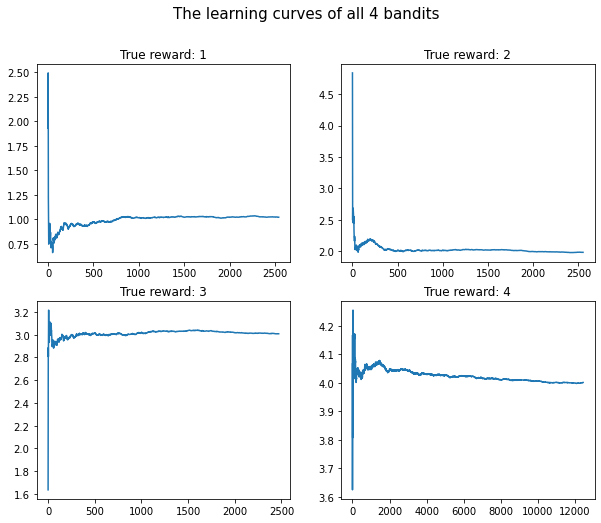


-= Part 2 =-


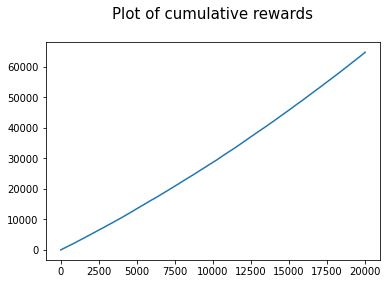

The sum reward for the experiment is 64842.390954259645
The cumulative reward for the experiment is [4.83830880e+00 6.98042237e+00 7.48567116e+00 ... 6.48318617e+04
 6.48377105e+04 6.48423910e+04]

The sum of regret for the experiment is -44.39095425968425
The cumulative regret for the experiment is [ -2.8383088   -2.98042237  -1.48567116 ... -41.86171656 -43.71048113
 -44.39095426]


In [14]:
eps_rewards = EpsilonGreedyBandit(Bandit).experiment(bandit_rewards_list, num_trials, './data/EpsilonGreedy.csv', to_save=True)

In [15]:
class ThompsonSamplingBandit(Bandit):
    """ 
    Represents a epsilon greedy bandit with the following attributes and methods.
    
    Attributes:
        reward (float): The true reward of the bandit.
    Methods:
        pull(): Pulls a value for the bandit.
        sample(): Samples a value from the estimated reward.
        update(x: float): Updates the estimated reward of the bandit.
        plot1(): Plots the learning process of the bandits.
        experiment(bandit_rewards: list, num_trials: int, path_to_save: str, to_save: bool): Run the experiment with given bandits, number of trials and whether to save the results or not.
        report(path_to_save: str, to_save: bool): Prints the report of the experiment.
        create_data(): Creates the dataframe for saving
        update_epsilon(): Updates the epsilon with rate 1/t.
    """
    def __init__(self, reward):
        """
        Initilizes a new instance of ThompsonSamplingBandit class with the following arguments:
        
        Args:
            reward (float): The true reward of the bandit. 
        
        """
        self.reward = reward    #The true reward
        self.m = 0    #The estimated reward
        self.lambda_ = 1    #Parameter lambda
        self.tau = 1    #Parameter tau
        self.N = 0    #Iteration count
        self.sum_x = 0    #Cumulative reward
        self.learning_process = []    #Learning process list

    def pull(self):
        """
        Pulls a value for the bandit based on the true reward (the value is pulled from normal distribution with mean = "true bandit reward" and 1 std).
        
        """
        return np.random.randn() / np.sqrt(self.tau) + self.reward
    
    def sample(self):
        """
        Samples a value for the bandit based on the estimated reward.
        """
        return np.random.randn() / np.sqrt(self.lambda_) + self.m
    
    def update(self, x):
        """
        Updates the estimated reward for the bandit based on the new, pulled value.
        
        Args:
            x (float): The new value pulled for the bandit, the value to update for the estimated reward.
        
        """
        self.lambda_ += self.tau    #Update lambda
        self.sum_x+=x    #Update the cumulative sum
        self.m = (self.tau * self.sum_x)/self.lambda_    #Update the reward estimate
        self.learning_process.append(self.m)    #Learning process update list
        self.N += 1    #Increment iteration count

        
    def __repr__(self):
        return f'A bandit with actual reward: {self.reward} and estimated reward {self.m}'
    
    def plot1(self):
        """
        Plots the learning curves after the experiment for the existing bandits. Creates a subplot of all the bandits learning curves.
        
        """
        fig, axs = plt.subplots(2, 2, figsize = (10, 8))
        plt.suptitle('The learning curves of all 4 bandits', size=15)
        for index, bandit in enumerate(self.bandits):
            x_index = 1 if index>=2 else 0 
            y_index = index%2
            axs[x_index, y_index].plot(bandit.learning_process)
            axs[x_index, y_index].set_title(f'True reward: {bandit.reward}')
        plt.show()
            
    def experiment(self, bandit_rewards, num_trials, path_to_save, to_save=False):
        """
        The experiment function that runs the experiment with the given bandit rewards and number of trials.
        
        Args:
            bandit_rewards (list): The true rewards list of bandits.
            num_trials (int): The number of iterations to run the experiment.
            path_to_save (str): The path to save the results.
            to_save (bool): Whether to save the results or not.
            
        """
        if to_save:    #if save create data
            self.create_data()
        self.bandits = [ThompsonSamplingBandit(reward) for reward in bandit_rewards]    #Initialize bandits
        self.rewards = np.zeros(num_trials)    #Create reward array
        self.regret = []
        for i in range(num_trials):
            index = np.argmax([b.sample() for b in self.bandits])    #Sample from bandit rewards
            selected_bandit = self.bandits[index]
            x = selected_bandit.pull()
            if to_save:
                new_row = {'Bandit': index, 'Reward': x, 'Algorithm': selected_bandit.__class__.__name__}
                self.data = self.data.append(new_row, ignore_index=True)             
            self.rewards[i] = x
            self.regret.append(selected_bandit.reward - x)
            selected_bandit.update(x)
        self.report(path_to_save, to_save) 
        return self.rewards

    def report(self, path_to_save, to_save=False):
        """
        The report function that prints the report for the experiment.
        
        Args:
            path_to_save (str): The path to save the results of the experiment.
            to_save (bool): Whether to save the results or not.
        
        """
        if self.bandits is None:
            raise Exception('Run the experiment first')
        print(' '*35 +'\033[1m' + 'Report' + '\033[0m')
        #Part1   
        self.plot1()
        
        #Part2
        cumulative_rewards = np.cumsum(self.rewards)
        plt.plot(cumulative_rewards)
        plt.title('Plot of cumulative rewards\n', size = 15)
        plt.show()
        
        #Part3
        if to_save:
            self.data.to_csv(path_to_save, index=False)
            
        #Part4
        cumulative_reward = cumulative_rewards[-1]
        print(f'The sum reward for the experiment is {cumulative_reward}')
        print(f'The cumulative reward for the experiment is {cumulative_rewards}')
        
        #Part5
        cumulative_regrets = np.cumsum(self.regret)
        cumulative_regret = cumulative_regrets[-1]
        print(f'\nThe sum of regret for the experiment is {cumulative_regret}')
        print(f'The cumulative regret for the experiment is {cumulative_regrets}')

    def create_data(self):
        """
        Creates the dataset for storing data.
        
        """
        self.data = pd.DataFrame(columns=['Bandit', 'Reward', 'Algorithm'])
        print('The dataframe for storing data is created.')


The dataframe for storing data is created.
                                   Report


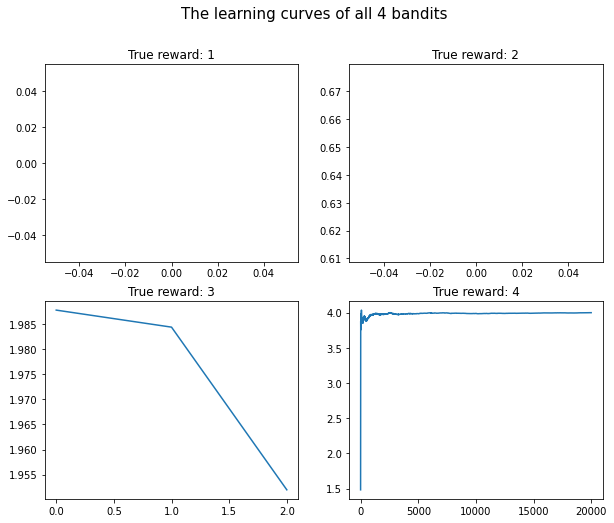

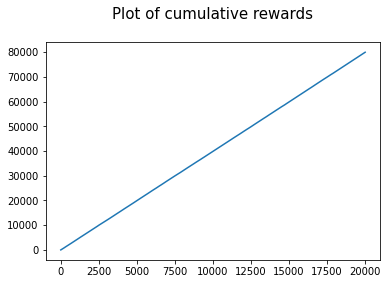

The sum reward for the experiment is 79970.51593111831
The cumulative reward for the experiment is [2.96456266e+00 4.25320327e+00 8.22872728e+00 ... 7.99634124e+04
 7.99661915e+04 7.99705159e+04]

The sum of regret for the experiment is 24.484068881656338
The cumulative regret for the experiment is [ 1.03543734  1.74679673  0.77127272 ... 23.5875806  24.80850669
 24.48406888]


In [16]:
thompson_rewards = ThompsonSamplingBandit(Bandit).experiment(bandit_rewards_list, num_trials, './data/ThompsonSampling.csv', to_save=True)

In [17]:
def comparison(eps_reward, thompson_reward, num_trials):   
    """
    A function for comparing Epsilon Greedy with Thompson Sampling algorithms.
    
    Args:
    
        eps_reward (list): Epsilon rewards.
        thompson_reward(list): Thompson rewards.
        num_trails (int): The number of trials.
    
    """
    plt.plot(np.arange(num_trials), np.cumsum(eps_reward), label='Epsilon-Greedy')
    plt.plot(np.arange(num_trials), np.cumsum(thompson_reward), label='Thompson Sampling')
    plt.xlabel('#Trials')
    plt.ylabel('Estimated Reward')
    plt.title('Comparison of Epsilon-Greedy and Thompson Sampling')
    plt.legend()
    plt.show()

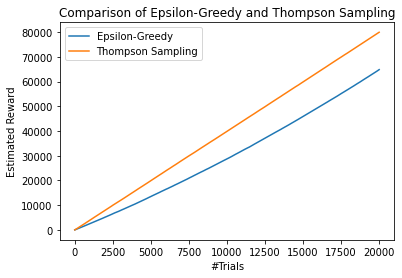

In [18]:
comparison(eps_rewards, thompson_rewards, num_trials)

# Results

In summary, Thompson Sampling is a probabilistic algorithm that dynamically adjusts its exploration based on the observed rewards, while Epsilon-Greedy is a deterministic algorithm that balances exploration and exploitation based on a fixed epsilon value (or adjusting epsilon value). Thompson Sampling is generally considered more sophisticated and capable of achieving better performance in uncertain environments, while Epsilon-Greedy is simpler and easier to implement but may require careful tuning of the epsilon value for the optimal results.

In our experiment, it is visible how Thopson Sampling achieves higher estimated reward through the experiment.